# Clustering metrics - alternatives to the _elbow method_
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536

Clustering is an important part of the machine learning pipeline for business or scientific enterprises utilizing data science. As the name suggests, it helps to identify congregations of closely related (by some measure of distance) data points in a blob of data, which, otherwise, would be difficult to make sense of.

A popular method like k-means clustering does not seem to provide a completely satisfactory answer when we ask the basic question: 
> **"How would we know the actual number of clusters, to begin with?"**

This question is critically important because of the fact that the process of clustering is often a precursor to further processing of the individual cluster data and therefore, the amount of computational resource may depend on this measurement. 

In the case of a business analytics problem, repercussion could be worse. Clustering is often done for such analytics with the goal of market segmentation. It is, therefore, easily conceivable that, depending on the number of clusters, appropriate marketing personnel will be allocated to the problem. Consequently, a wrong assessment of the number of clusters can lead to sub-optimum allocation of precious resources.

For the k-means clustering method, the most common approach for answering this question is the so-called elbow method. It involves running the algorithm multiple times over a loop, with an increasing number of cluster choice and then plotting a clustering score as a function of the number of clusters.

In this notebook, we show what metric to use for visualizing and determining an optimal number of clusters much better than the usual practice - elbow method.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Create synthetic data using Scikit learn `make_blob` method

- Number of features: 4
- Number of clusters: 5
- Number of samples: 200

In [2]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

In [3]:
# set parameters for making blobs
n_features = 4
n_cluster = 5
cluster_std = 1.2
n_samples = 200

In [7]:
# make blobs
data1 = make_blobs(n_samples=n_samples,n_features=n_features,centers=n_cluster,cluster_std=cluster_std)

In [10]:
# check the returned object (tuple)
data1[0].shape, data1[1].shape    # [0]: 4-dimensional data, [1]: cluster label

((200, 4), (200,))

In [11]:
# get 4-dimensional data points
d1 = data1[0]

In [12]:
# store data in dataframe
df1 = pd.DataFrame(data = d1,
                   columns = ['Feature_'+str(i) for i in range(1,n_features+1)])
df1.head()

,Feature_1,Feature_2,Feature_3,Feature_4
0,1.592743,8.405938,-9.388041,2.601135
1,2.578754,9.596447,-10.691882,0.526451
2,10.479421,0.707875,-6.022393,-1.979250
3,0.443617,7.784014,-8.658945,1.669623
4,4.673225,7.108281,-6.256677,6.000962


In [13]:
from itertools import combinations

In [15]:
# list all the combinations for 2 out of 4 features 
#    combinations(iterable, r) --> returns successive r-length combinations of elements in the iterable

lst_vars = list(combinations(df1.columns,2))
lst_vars

[('Feature_1', 'Feature_2'),
 ('Feature_1', 'Feature_3'),
 ('Feature_1', 'Feature_4'),
 ('Feature_2', 'Feature_3'),
 ('Feature_2', 'Feature_4'),
 ('Feature_3', 'Feature_4')]

In [18]:
# show the number of resulting combinations
len(lst_vars)

6

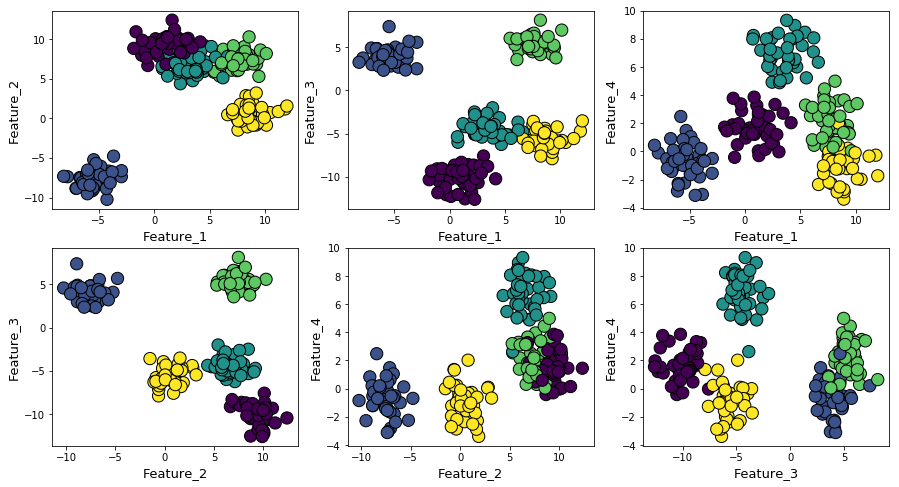

In [19]:
# plot the blobs in 2D for each 2-length combinations of 4 features

plt.figure(figsize=(15,8))

for i in range(1,7):       # loop over all 6 combinations
    
    plt.subplot(2,3,i)
    
    dim1=lst_vars[i-1][0]  # get first feature within current combination
    dim2=lst_vars[i-1][1]  # get second feature within current combination
    
    plt.scatter(df1[dim1], df1[dim2], 
                c=data1[1], edgecolor='k', s=150)   # color clusters by cluster label (0-4, see above)
    plt.xlabel(f"{dim1}",fontsize=13)
    plt.ylabel(f"{dim2}",fontsize=13)

### How are the classes separated (boxplots)

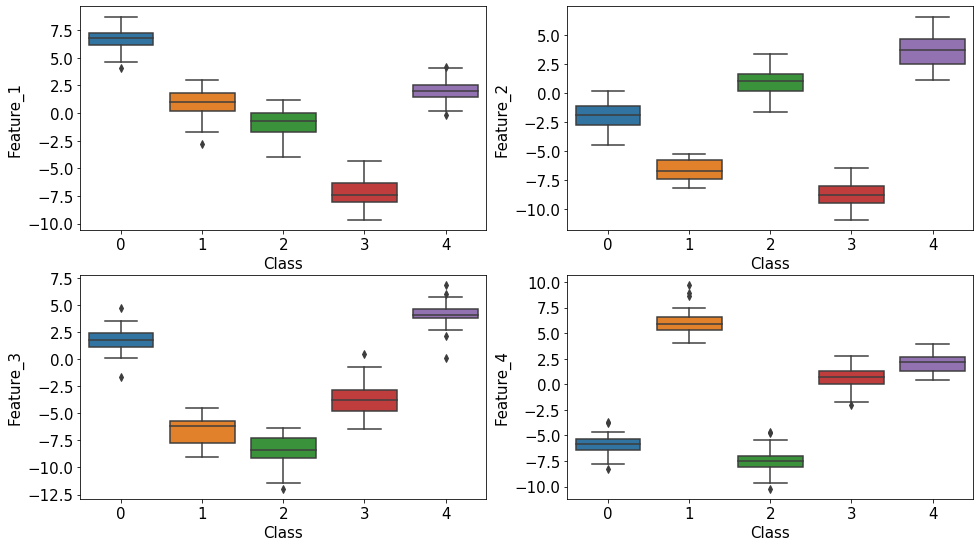

In [11]:
# generate boxplots showing the distribution of each feature for each cluster

plt.figure(figsize=(16,14))
for i,c in enumerate(df1.columns):     # loop over the features (columns)
    plt.subplot(3,2,i+1)
    sns.boxplot(y=df1[c],x=data1[1])   # y = current feature (1-4), x = cluster labels (0-4)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Class",fontsize=15)
    plt.ylabel(c,fontsize=15)
    #plt.show()

## k-means clustering

In [20]:
#import module
from sklearn.cluster import KMeans

### Unlabled data

In [27]:
X=df1       # feature values for each point
X.head()   

,Feature_1,Feature_2,Feature_3,Feature_4
0,1.592743,8.405938,-9.388041,2.601135
1,2.578754,9.596447,-10.691882,0.526451
2,10.479421,0.707875,-6.022393,-1.979250
3,0.443617,7.784014,-8.658945,1.669623
4,4.673225,7.108281,-6.256677,6.000962


In [38]:
y=data1[1]   # cluster labels (0-4)

### Scaling

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
# initialize scaler - here: MinMax scaling
scaler = MinMaxScaler()

In [30]:
# check min and max for each feature BEFORE scaling
print(X.min())
print(X.max())  

Feature_1    -8.162606
Feature_2   -10.234095
Feature_3   -12.621178
Feature_4    -3.391449
dtype: float64
Feature_1    11.982722
Feature_2    12.374490
Feature_3     8.133652
Feature_4     9.308018
dtype: float64


In [25]:
# scale X using MinMax scaler (fit scaler and transform with scaler in one step)
X_scaled = scaler.fit_transform(X)

In [35]:
# check min and max for each feature AFTER scaling --> all features scaled to min=0 and max=1
print(X_scaled.min(axis=0))
print(X_scaled.max(axis=0)) 

[0. 0. 0. 0.]
[1. 1. 1. 1.]


### Metrics

In [36]:
# import cluster metrics from sklearn
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score

- **Kmeans score:** is the sum of square distances from each point to its assigned center
- **Silhouette score:** is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- **Davies-Bouldin score:** is the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.
- **V-Measure:** is defined as the harmonic mean of homogeneity and completeness of the clustering. Both these measures can be expressed in terms of the mutual information and entropy measures of the information theory. Homogeneity is maximized when each cluster contains elements of as few different classes as possible.

### Running k-means and computing inter-cluster distance score for various *k* values

In [39]:
# initialize empty lists to store clustering metrics for KMeans
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []

# loop over different k's (from 2 to 11): fit KMeans model and store metrics in list
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    v_measure = v_measure_score(y,preds)
    vmeasure_score.append(v_measure)
    print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
    print("-"*100)

Score for number of cluster(s) 2: -30.562104980166403
Silhouette score for number of cluster(s) 2: 0.5193070634373024
Davies Bouldin score for number of cluster(s) 2: 0.6011318590325687
V-measure score for number of cluster(s) 2: 0.47435098761403227
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 3: -17.69445491779883
Silhouette score for number of cluster(s) 3: 0.5183497568701698
Davies Bouldin score for number of cluster(s) 3: 0.9264853083279189
V-measure score for number of cluster(s) 3: 0.7918756684685209
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 4: -8.953237684910363
Silhouette score for number of cluster(s) 4: 0.6320801408134034
Davies Bouldin score for number of cluster(s) 4: 0.5717747195813322
V-measure score for number of cluster(s) 4: 0.905746099275519
-----------------------------------------------------

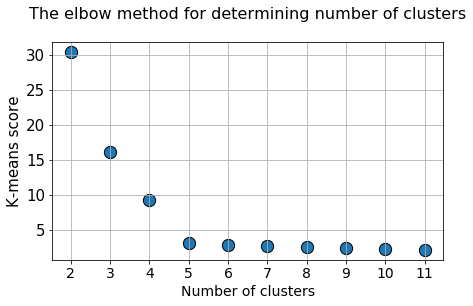

In [21]:
# plot the K-means score for different k's:  --> minimum at k=5
# K-means score is the sum of square distances from each point to its assigned center

plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

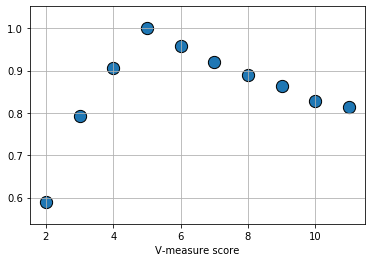

In [22]:
# plot the V-measure score for different k's:  --> maximum at k=5

# V-Measure is defined as the harmonic mean of homogeneity and completeness of the clustering. 
# Both these measures can be expressed in terms of the mutual information and entropy measures 
# of the information theory. Homogeneity is maximized when each cluster contains elements of 
# as few different classes as possible.
    
plt.scatter(x=[i for i in range(2,12)],y=vmeasure_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("V-measure score")
plt.show()

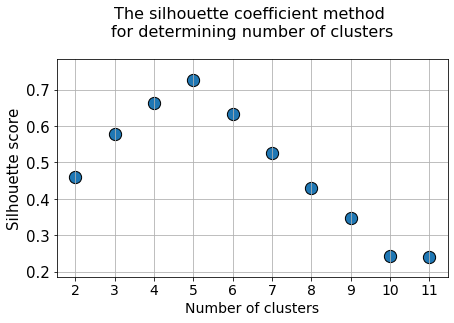

In [23]:
# plot the silhouette coefficient for different k's:  --> maximum at k=5

# Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other 
# clusters (separation), ranges from −1 to +1, where a high value indicates that the object is well matched 
# to its own cluster and poorly matched to neighboring clusters.

plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

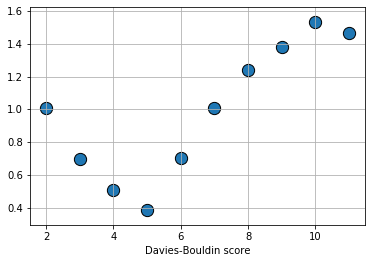

In [24]:
# plot the Davies-Bouldin score for different k's:  --> minimum at k=5

# Davies-Bouldin score is the average similarity measure of each cluster with its most similar cluster, 
# where similarity is the ratio of within-cluster distances to between-cluster distances. 
# Thus, clusters which are farther apart and less dispersed will result in a better score.

plt.scatter(x=[i for i in range(2,12)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

## Expectation-maximization (Gaussian Mixture Model)

In [42]:
#import Gaussian Mixture module from sklearn
from sklearn.mixture import GaussianMixture

In [43]:
# initialize empty lists to store clustering metrics for Gaussian Mixture Model
gm_bic= []
gm_score=[]

# loop over different components (from 2 to 11): fit model and store metrics in list

for i in range(2,12):
    gm = GaussianMixture(n_components=i, n_init=10, tol=1e-3, max_iter=1000).fit(X_scaled)
    
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(X_scaled)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X_scaled)))
    print("-"*100)
    
    gm_bic.append(-gm.bic(X_scaled))
    gm_score.append(gm.score(X_scaled))

BIC for number of cluster(s) 2: -682.2295300150103
Log-likelihood score for number of cluster(s) 2: 2.089701834112258
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: -1043.7163216209867
Log-likelihood score for number of cluster(s) 3: 3.1921057143727505
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: -1159.5688052685412
Log-likelihood score for number of cluster(s) 4: 3.680423824737188
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: -1188.5248234621995
Log-likelihood score for number of cluster(s) 5: 3.9515007714668853
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: -1132.2823443967682
Log-likelihood score for number of cluster(s) 6: 4.009581475048859


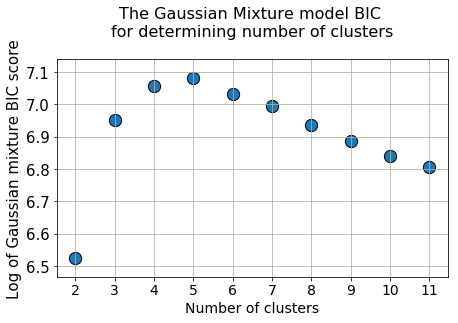

In [44]:
# plot the Log of BIC score for different components:  --> maximum at k=5

plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)

plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

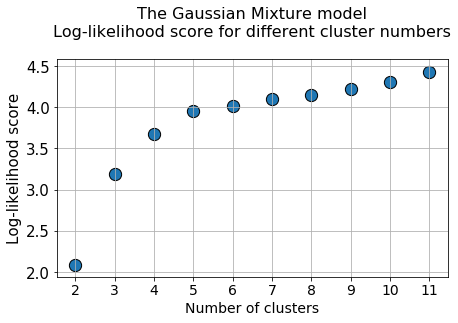

In [48]:
# plot the Log-likelihood score for different components:

plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model\nLog-likelihood score for different cluster numbers\n",fontsize=16)

plt.scatter(x=[i for i in range(2,12)],y=gm_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log-likelihood score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()